## Summary of Rejection Sampling

Rejection sampling is a computational technique used to sample from a target probability distribution $f(x)$ when direct sampling is challenging. The method utilizes a simpler proposal distribution $g(x)$ from which samples are easier to draw.

### Concept and Procedure

The essence of rejection sampling is to approximate the target distribution $f(x)$ using a proposal distribution $g(x)$ scaled by a constant $C$, such that $f(x) \leq C \cdot g(x)$ for all $x$. This ensures that the scaled proposal distribution encapsulates the target distribution.


The procedure involves the following steps:

1. **Define the Scaling Constant**:
   - Choose a constant $C$ such that the inequality $f(x) \leq C \cdot g(x)$ holds for all $x$. This constant effectively raises the proposal distribution to cover the entire area under the target distribution.

2. **Sampling and Acceptance**:
   - **Sample $x$ from $g(x)$**: 
      - Draw a sample $x$ from the proposal distribution $g(x)$.
   - **Generate a Uniform Random Value $u$**: 
      - Draw $u$ from a uniform distribution ranging between 0 and $C \cdot g(x)$, i.e., $u \sim U(0, C \cdot g(x))$.
   - **Acceptance Criterion**: 
      - Accept the sample $x$ if $u \leq f(x)$; otherwise, reject it. This condition ensures that the accepted samples are distributed according to $f(x)$.
   - Shown as the figure below (from https://www.youtube.com/watch?v=si76S7QqxTU&t=7s)

<div style="text-align: center;">
    <img src="images/reject_sampling_eg.jpg" alt="reject_sampling" width="700"/>
</div>

### Mathematical Formulation

The mathematical criterion for acceptance in rejection sampling can be expressed as follows:
$$ 
   u \sim U(0, C \cdot g(x)), 
   \text{accept if } u \leq f(x)
$$
This can also be rephrased to highlight the relationship between the proposal and target distributions without explicitly using $C$:
$$
   u \sim U(0, 1),
   \text{accept if } u \leq \frac{f(x)}{g(x) \cdot C}
$$

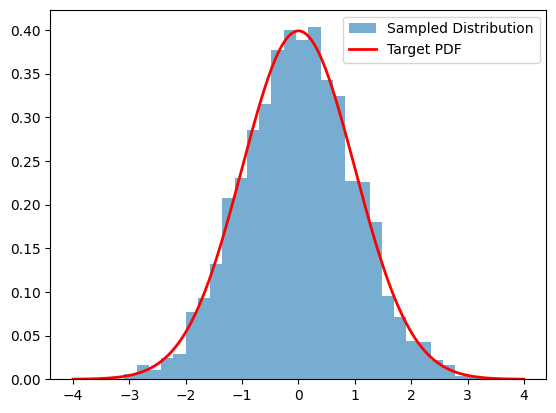

In [4]:
### General Rejection Sampling ###
'''
Using a Uniform Distribution to generate a Normal Distribution
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def target_pdf(x):
    """Define the target probability density function (PDF)."""
    return (1 / (np.sqrt(2 * np.pi) * 1)) * np.exp(-0.5 * ((x - 0) / 1)**2)

def rejection_sampling(target_pdf, domain, M, num_samples):
    """
    Perform rejection sampling given a target PDF.
    
    Parameters:
        target_pdf (function): The target probability density function.
        domain (tuple): The (min, max) tuple defining the domain of x.
        M (float): The upper limit for y values, should be >= max of target_pdf.
        num_samples (int): Number of samples to generate.
    
    Returns:
        np.array: Accepted x samples that follow the target distribution.
    """
    # Generate uniform samples for x in the given domain
    x_samples = np.random.uniform(domain[0], domain[1], num_samples)
    
    # Generate uniform samples for y between 0 and M
    y_samples = np.random.uniform(0, M, num_samples)
    
    # Evaluate the target PDF at each x sample
    pdf_values = target_pdf(x_samples)
    
    # Accept samples where the y value is less than the PDF value at x
    accepted_samples = x_samples[y_samples < pdf_values]
    
    return accepted_samples

# Usage of the rejection sampling function
num_samples = 10000
domain = (-4, 4)  # Define the domain for x
M = 0.5  # Set M to be the approximate max of the target PDF

# Perform rejection sampling
accepted_samples = rejection_sampling(target_pdf, domain, M, num_samples)

# Plotting the results
plt.hist(accepted_samples, bins=30, density=True, alpha=0.6, label='Sampled Distribution')
x_values = np.linspace(domain[0], domain[1], 400)
plt.plot(x_values, target_pdf(x_values), 'r-', lw=2, label='Target PDF')
plt.legend()
plt.show()


### Application in Causal Inference

- **Proposal Distribution $P(T)$**: 
   - This is typically the observed distribution of treatment across the dataset, reflecting how treatments were actually administered.
- **Target Distribution $P^*(T|C)$**: 
   - Represents the ideal distribution where treatment assignment is independent of confounding factors, akin to a randomized experiment.
- **Acceptance Criterion**:
   - Define $M$ as a scaling constant where $M \geq \sup \left( \frac{P^*(T|C)}{P(T)} \right)$. This constant $M$ effectively scales the proposal distribution to ensure that it envelops the target distribution.
   - Then the Acceptance Criterion is formulated as follows:
      $$
      u \sim U(0, 1), \quad \text{accept if } u \leq \frac{P^*(T|C)}{P(T) \cdot M}
      $$
- **Example**:
   - Assume we have a dataframe contains column '$T$' (binary treatment) and '$C$' (binary confounder). Then we have:
      $$
      P(T) \sim \text{Binomial}(\zeta),
      $$

      $$
      P^*(T|C) = \begin{cases} 
      \text{Binomial}(\zeta_0) & \text{if } C = 0, \\
      \text{Binomial}(\zeta_1) & \text{if } C = 1.
      \end{cases}
      $$
   - We can take the observed dataframe as the population of $P(T)$ and apply the reject sampling following the defination of $P^*(T|C)$


In [58]:
### Rejection Sampling in Causal Inference ###
import numpy as np
import pandas as pd
from scipy.special import expit  # Sigmoid function

def researcher_specified_function_for_confounding(data, confound_func_params):
    """
    Biasing function for sampling algorithms based on the covariate C.
    Calculates p(T|C) based on given parameters.
    """
    if confound_func_params["para_form"] == "linear":
        return expit(-1 + 2.5 * data["C"])
    elif confound_func_params["para_form"] == "binary_piecewise":
        return np.array([confound_func_params["zeta1"] if c == 1 else confound_func_params["zeta0"] for c in data["C"]])
    else:
        raise ValueError("Unsupported parameterization form.")

def rct_rejection_sampling(data, confound_func_params):
    """
    Perform RCT Rejection Sampling to mimic an RCT-like distribution of treatment based on covariate C.
    Adjusts for the condition whether T=1 or T=0 using p(T|C) and 1-p(T|C).
    """
    p_TC = researcher_specified_function_for_confounding(data, confound_func_params) # The true propensity score conditional on C
    p_T = data['T'].mean()

    # Adjust probabilities for T=0 cases
    p_TC_adj = np.where(data['T'] == 1, p_TC, 1 - p_TC)
    p_T_adj = np.where(data['T'] == 1, p_T, 1 - p_T)

    # Compute the ratio and M
    M = np.max(p_TC_adj) / np.min(p_T_adj)

    # Generate uniform random numbers
    uniform_random = np.random.uniform(0, 1, len(data))

    # Compute the acceptance threshold
    acceptance_threshold = p_TC_adj / (p_T_adj * M)

    # Accept or reject units
    accepted_indices = uniform_random < acceptance_threshold

    # Return the subset of data that has been accepted
    return data[accepted_indices]

def P_TC(data):
    class_0_TC = data[data['C']==0]['T'].mean()
    class_1_TC = data[data['C']==1]['T'].mean()
    print(f'Probability of treatment when C=0 is:{class_0_TC}')
    print(f'Probability of treatment when C=1 is:{class_1_TC}')
    
# Example usage
np.random.seed(42)
data = pd.read_csv('data/subpopA_physics_medicine.csv')
confound_func_params = {
    "para_form": "binary_piecewise",
    "zeta0": 0.1,  # Probability of treatment when C=0
    "zeta1": 0.9   # Probability of treatment when C=1
}

sampled_data = rct_rejection_sampling(data, confound_func_params)
print("Original data count:", len(data))
print("Sampled data count:", len(sampled_data))





Original data count: 4379
Sampled data count: 2362


In [59]:
P_TC(sampled_data)

Probability of treatment when C=0 is:0.10208816705336426
Probability of treatment when C=1 is:0.8943552563438633
